In [103]:
import kagglehub
import os
import shutil
import pandas as pd

In [104]:
path = kagglehub.dataset_download("nikhil7280/weather-type-classification")

dest = os.getcwd()
full_file_name = ""

# Copy all files from cache path into your current folder
for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)


In [105]:
df = pd.read_csv(full_file_name)

In [106]:
df.head(5)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [107]:
from sklearn.model_selection import train_test_split

# Спочатку розділяємо на train (70%) і temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Weather Type'])

# Потім розділяємо temp (30%) на validation (15%) і test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Weather Type'])

print(f"Тренувальна вибірка: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Валідаційна вибірка: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Тестова вибірка: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"\nЗагальна кількість: {len(train_df) + len(val_df) + len(test_df)}")

Тренувальна вибірка: 9240 (70.0%)
Валідаційна вибірка: 1980 (15.0%)
Тестова вибірка: 1980 (15.0%)

Загальна кількість: 13200


In [108]:
print("Розподіл класів у тренувальній вибірці:")
print(train_df['Weather Type'].value_counts().sort_index())
print("\nРозподіл класів у валідаційній вибірці:")
print(val_df['Weather Type'].value_counts().sort_index())
print("\nРозподіл класів у тестовій вибірці:")
print(test_df['Weather Type'].value_counts().sort_index())

Розподіл класів у тренувальній вибірці:
Weather Type
Cloudy    2310
Rainy     2310
Snowy     2310
Sunny     2310
Name: count, dtype: int64

Розподіл класів у валідаційній вибірці:
Weather Type
Cloudy    495
Rainy     495
Snowy     495
Sunny     495
Name: count, dtype: int64

Розподіл класів у тестовій вибірці:
Weather Type
Cloudy    495
Rainy     495
Snowy     495
Sunny     495
Name: count, dtype: int64


In [109]:
# Перевіримо наявність NaN значень
print("Кількість NaN значень у кожному стовпці:\n")
print(train_df.isnull().sum())
print(f"\nЗагальна кількість NaN: {train_df.isnull().sum().sum()}")
print(f"Відсоток пропущених значень: {train_df.isnull().sum().sum() / (train_df.shape[0] * train_df.shape[1]) * 100:.2f}%")

Кількість NaN значень у кожному стовпці:

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

Загальна кількість NaN: 0
Відсоток пропущених значень: 0.00%


## Кодування категоріальних ознак

**Обрані методи:**
- **Label Encoding** для ординальних ознак (Season - має природній порядок)
- **One-Hot Encoding** для номінальних ознак (Cloud Cover, Location - немає порядку)

**Обґрунтування:**
- Season (Winter→Spring→Summer→Autumn) має природній порядок, тому Label Encoding зберігає цю інформацію
- Cloud Cover (clear, partly cloudy, overcast) теж порядкується
- Location (inland, coastal, mountain) не мають порядку, тому One-Hot Encoding уникає помилкових залежностей

In [110]:
# Подивимось на унікальні значення категоріальних ознак
print("Унікальні значення категоріальних ознак:\n")
categorical_features = ['Cloud Cover', 'Season', 'Location']

for col in categorical_features:
    print(f"{col}: {train_df[col].unique()}")

Унікальні значення категоріальних ознак:

Cloud Cover: ['partly cloudy' 'overcast' 'clear' 'cloudy']
Season: ['Winter' 'Autumn' 'Spring' 'Summer']
Location: ['coastal' 'mountain' 'inland']


In [111]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Створюємо копії для кодування
train_encoded = train_df.copy()
val_encoded = val_df.copy()
test_encoded = test_df.copy()


# Label Encoding для Cloud Cover (ordinal)
cloud_order = {'clear': 0, 'partly cloudy': 1, 'cloudy': 2, 'overcast': 3}
train_encoded['Cloud Cover'] = train_df['Cloud Cover'].map(cloud_order)
val_encoded['Cloud Cover'] = val_df['Cloud Cover'].map(cloud_order)
test_encoded['Cloud Cover'] = test_df['Cloud Cover'].map(cloud_order)

print(f"✓ Cloud Cover закодовано (Label Encoding):")
print(f"  {cloud_order}")

✓ Cloud Cover закодовано (Label Encoding):
  {'clear': 0, 'partly cloudy': 1, 'cloudy': 2, 'overcast': 3}


In [112]:
# 2. One-Hot Encoding для Season та Location (номінальні ознаки)
# Використовуємо pd.get_dummies, але важливо зберегти ті ж колонки для всіх вибірок

# Спочатку перетворюємо тренувальні дані
train_encoded = pd.get_dummies(train_encoded, columns=['Season', 'Location'], prefix=['Season', 'Loc'])

# Отримуємо список колонок після One-Hot Encoding
one_hot_columns = [col for col in train_encoded.columns if col.startswith('Season_') or col.startswith('Loc_')]

# Перетворюємо val та test, потім вирівнюємо колонки
val_encoded = pd.get_dummies(val_encoded, columns=['Season', 'Location'], prefix=['Season', 'Loc'])
test_encoded = pd.get_dummies(test_encoded, columns=['Season', 'Location'], prefix=['Season', 'Loc'])

# Переконуємось що всі вибірки мають ті ж колонки
for col in train_encoded.columns:
    if col not in val_encoded.columns:
        val_encoded[col] = 0
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# Впорядковуємо колонки однаково
val_encoded = val_encoded[train_encoded.columns]
test_encoded = test_encoded[train_encoded.columns]

print("✓ Season та Location закодовано (One-Hot Encoding)")
print(f"\nНові колонки після One-Hot Encoding:")
print(f"  {[col for col in one_hot_columns]}")
print(f"\nЗагальна кількість колонок: {len(train_encoded.columns)}")

✓ Season та Location закодовано (One-Hot Encoding)

Нові колонки після One-Hot Encoding:
  ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Loc_coastal', 'Loc_inland', 'Loc_mountain']

Загальна кількість колонок: 16


In [113]:
# Перегляд результату кодування
print("Приклад закодованих даних (перші 3 рядки):\n")
display_cols = ['Temperature', 'Cloud Cover', 'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
                'Loc_coastal', 'Loc_inland', 'Loc_mountain', 'Weather Type']
print(train_encoded[display_cols].head(3))

Приклад закодованих даних (перші 3 рядки):

       Temperature  Cloud Cover  Season_Autumn  Season_Spring  Season_Summer  \
2107          11.0            1          False          False          False   
12782         -2.0            3          False          False          False   
7581          28.0            1           True          False          False   

       Season_Winter  Loc_coastal  Loc_inland  Loc_mountain Weather Type  
2107            True         True       False         False       Cloudy  
12782           True        False       False          True        Snowy  
7581           False        False       False          True        Sunny  


## Нормалізація числових даних

Нормалізуємо числові ознаки (включаючи закодовані категоріальні) за формулою: `(x - mean) / std`

**Важливо:** Mean та std розраховуються **тільки на тренувальних даних** і застосовуються до всіх трьох вибірок для уникнення data leakage.

In [114]:
for col in train_encoded.columns:
    print(f"{col}: {train_encoded[col].dtype}")

Temperature: float64
Humidity: int64
Wind Speed: float64
Precipitation (%): float64
Cloud Cover: int64
Atmospheric Pressure: float64
UV Index: int64
Visibility (km): float64
Weather Type: object
Season_Autumn: bool
Season_Spring: bool
Season_Summer: bool
Season_Winter: bool
Loc_coastal: bool
Loc_inland: bool
Loc_mountain: bool


In [115]:
# Створимо копії DataFrame для збереження оригінальних даних
train_normalized = train_encoded.copy()
val_normalized = val_encoded.copy()
test_normalized = test_encoded.copy()

# Визначимо числові колонки (виключаємо категоріальні)
numeric_features = train_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Числові ознаки для нормалізації:", numeric_features)

# Обраховуємо mean та std ТІЛЬКИ на тренувальних даних
normalization_params = {}
for col in numeric_features:
    mean_val = train_encoded[col].mean()
    std_val = train_encoded[col].std()
    normalization_params[col] = {'mean': mean_val, 'std': std_val}
    
    print(f"\n{col}:")
    print(f"  Mean: {mean_val:.4f}")
    print(f"  Std:  {std_val:.4f}")

Числові ознаки для нормалізації: ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']

Temperature:
  Mean: 19.1173
  Std:  17.3920

Humidity:
  Mean: 68.5589
  Std:  20.1721

Wind Speed:
  Mean: 9.8951
  Std:  6.8923

Precipitation (%):
  Mean: 53.4538
  Std:  31.9688

Cloud Cover:
  Mean: 1.7903
  Std:  1.1889

Atmospheric Pressure:
  Mean: 1005.6013
  Std:  37.5426

UV Index:
  Mean: 3.9800
  Std:  3.8500

Visibility (km):
  Mean: 5.4538
  Std:  3.3667


In [116]:
# Застосовуємо нормалізацію: (x - mean) / std
for col in numeric_features:
    mean_val = normalization_params[col]['mean']
    std_val = normalization_params[col]['std']
    
    # Нормалізуємо всі три вибірки використовуючи параметри з train
    train_normalized[col] = (train_encoded[col] - mean_val) / std_val
    val_normalized[col] = (val_encoded[col] - mean_val) / std_val
    test_normalized[col] = (test_encoded[col] - mean_val) / std_val

print("✓ Нормалізація завершена")
print(f"\nПеревірка нормалізованих тренувальних даних:")
print(f"Mean Temperature (має бути ~0): {train_normalized['Temperature'].mean():.6f}")
print(f"Std Temperature (має бути ~1): {train_normalized['Temperature'].std():.6f}")

✓ Нормалізація завершена

Перевірка нормалізованих тренувальних даних:
Mean Temperature (має бути ~0): -0.000000
Std Temperature (має бути ~1): 1.000000


In [117]:
# Порівняємо оригінальні та нормалізовані дані
print("Приклад нормалізації (перші 3 рядки):\n")
print("ОРИГІНАЛЬНІ ДАНІ:")
print(train_df[numeric_features].head(3))
print("\nНОРМАЛІЗОВАНІ ДАНІ:")
print(train_normalized[numeric_features].head(3))

Приклад нормалізації (перші 3 рядки):

ОРИГІНАЛЬНІ ДАНІ:
       Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
2107          11.0        68         3.5               31.0  partly cloudy   
12782         -2.0        99        31.5               89.0       overcast   
7581          28.0        67         3.0               11.0  partly cloudy   

       Atmospheric Pressure  UV Index  Visibility (km)  
2107                 902.53         8              9.0  
12782                991.12         4              0.5  
7581                1028.93         7              9.5  

НОРМАЛІЗОВАНІ ДАНІ:
       Temperature  Humidity  Wind Speed  Precipitation (%)  Cloud Cover  \
2107     -0.466726 -0.027705   -0.927871          -0.702365    -0.664689   
12782    -1.214194  1.509073    3.134656           1.111902     1.017515   
7581      0.510733 -0.077279   -1.000416          -1.327974    -0.664689   

       Atmospheric Pressure  UV Index  Visibility (km)  
2107              -

## Частина 2. Побудова дерев рішень

Побудуємо 3 різні дерева рішень з різною глибиною:
- **Дерево 1**: max_depth = 3 (мале дерево)
- **Дерево 2**: max_depth = 10 (середнє дерево)
- **Дерево 3**: max_depth = None (без обмежень)

In [118]:
# Підготуємо дані для навчання моделей
# Відокремимо ознаки (X) від цільової змінної (y)

X_train = train_normalized.drop('Weather Type', axis=1)
y_train = train_normalized['Weather Type']

X_val = val_normalized.drop('Weather Type', axis=1)
y_val = val_normalized['Weather Type']

X_test = test_normalized.drop('Weather Type', axis=1)
y_test = test_normalized['Weather Type']

print("Форма тренувальних даних:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nФорма валідаційних даних:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"\nФорма тестових даних:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nНазви ознак ({len(X_train.columns)}):")
print(list(X_train.columns))

Форма тренувальних даних:
  X_train: (9240, 15)
  y_train: (9240,)

Форма валідаційних даних:
  X_val: (1980, 15)
  y_val: (1980,)

Форма тестових даних:
  X_test: (1980, 15)
  y_test: (1980,)

Назви ознак (15):
['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)', 'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Loc_coastal', 'Loc_inland', 'Loc_mountain']


In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Створимо три дерева з різною глибиною
trees = {
    'Дерево 1 (depth=3)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Дерево 2 (depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Дерево 3 (без обмежень)': DecisionTreeClassifier(random_state=42)
}

# Навчимо моделі та збережемо результати
results = {}

print("=" * 80)
print("НАВЧАННЯ ДЕРЕВ РІШЕНЬ")
print("=" * 80)

for name, model in trees.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Вимірюємо час навчання
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Передбачення на тренувальній та валідаційній вибірках
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Обчислюємо точність
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Зберігаємо результати
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': training_time,
        'depth': model.get_depth(),
        'n_leaves': model.get_n_leaves()
    }
    
    print(f"  Час навчання: {training_time:.4f} сек")
    print(f"  Фактична глибина дерева: {model.get_depth()}")
    print(f"  Кількість листків: {model.get_n_leaves()}")
    print(f"  Точність на тренувальній вибірці: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Точність на валідаційній вибірці: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"  Різниця (overfitting): {(train_accuracy - val_accuracy)*100:.2f}%")

print("\n" + "=" * 80)

НАВЧАННЯ ДЕРЕВ РІШЕНЬ

Дерево 1 (depth=3)
--------------------------------------------------------------------------------
  Час навчання: 0.0131 сек
  Фактична глибина дерева: 3
  Кількість листків: 8
  Точність на тренувальній вибірці: 0.8776 (87.76%)
  Точність на валідаційній вибірці: 0.8737 (87.37%)
  Різниця (overfitting): 0.39%

Дерево 2 (depth=10)
--------------------------------------------------------------------------------
  Час навчання: 0.0374 сек
  Фактична глибина дерева: 10
  Кількість листків: 220
  Точність на тренувальній вибірці: 0.9588 (95.88%)
  Точність на валідаційній вибірці: 0.9096 (90.96%)
  Різниця (overfitting): 4.92%

Дерево 3 (без обмежень)
--------------------------------------------------------------------------------
  Час навчання: 0.0391 сек
  Фактична глибина дерева: 20
  Кількість листків: 521
  Точність на тренувальній вибірці: 1.0000 (100.00%)
  Точність на валідаційній вибірці: 0.9101 (91.01%)
  Різниця (overfitting): 8.99%



In [120]:
# Створимо порівняльну таблицю результатів
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Модель': name,
        'Max Depth': name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None',
        'Фактична глибина': res['depth'],
        'Кількість листків': res['n_leaves'],
        'Train Accuracy': f"{res['train_accuracy']:.4f}",
        'Val Accuracy': f"{res['val_accuracy']:.4f}",
        'Overfitting': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%",
        'Час навчання (сек)': f"{res['training_time']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== ПОРІВНЯЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ ===\n")
print(comparison_df.to_string(index=False))


=== ПОРІВНЯЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ ===

                 Модель Max Depth  Фактична глибина  Кількість листків Train Accuracy Val Accuracy Overfitting Час навчання (сек)
     Дерево 1 (depth=3)         3                 3                  8         0.8776       0.8737       0.39%             0.0131
    Дерево 2 (depth=10)        10                10                220         0.9588       0.9096       4.92%             0.0374
Дерево 3 (без обмежень)      None                20                521         1.0000       0.9101       8.99%             0.0391


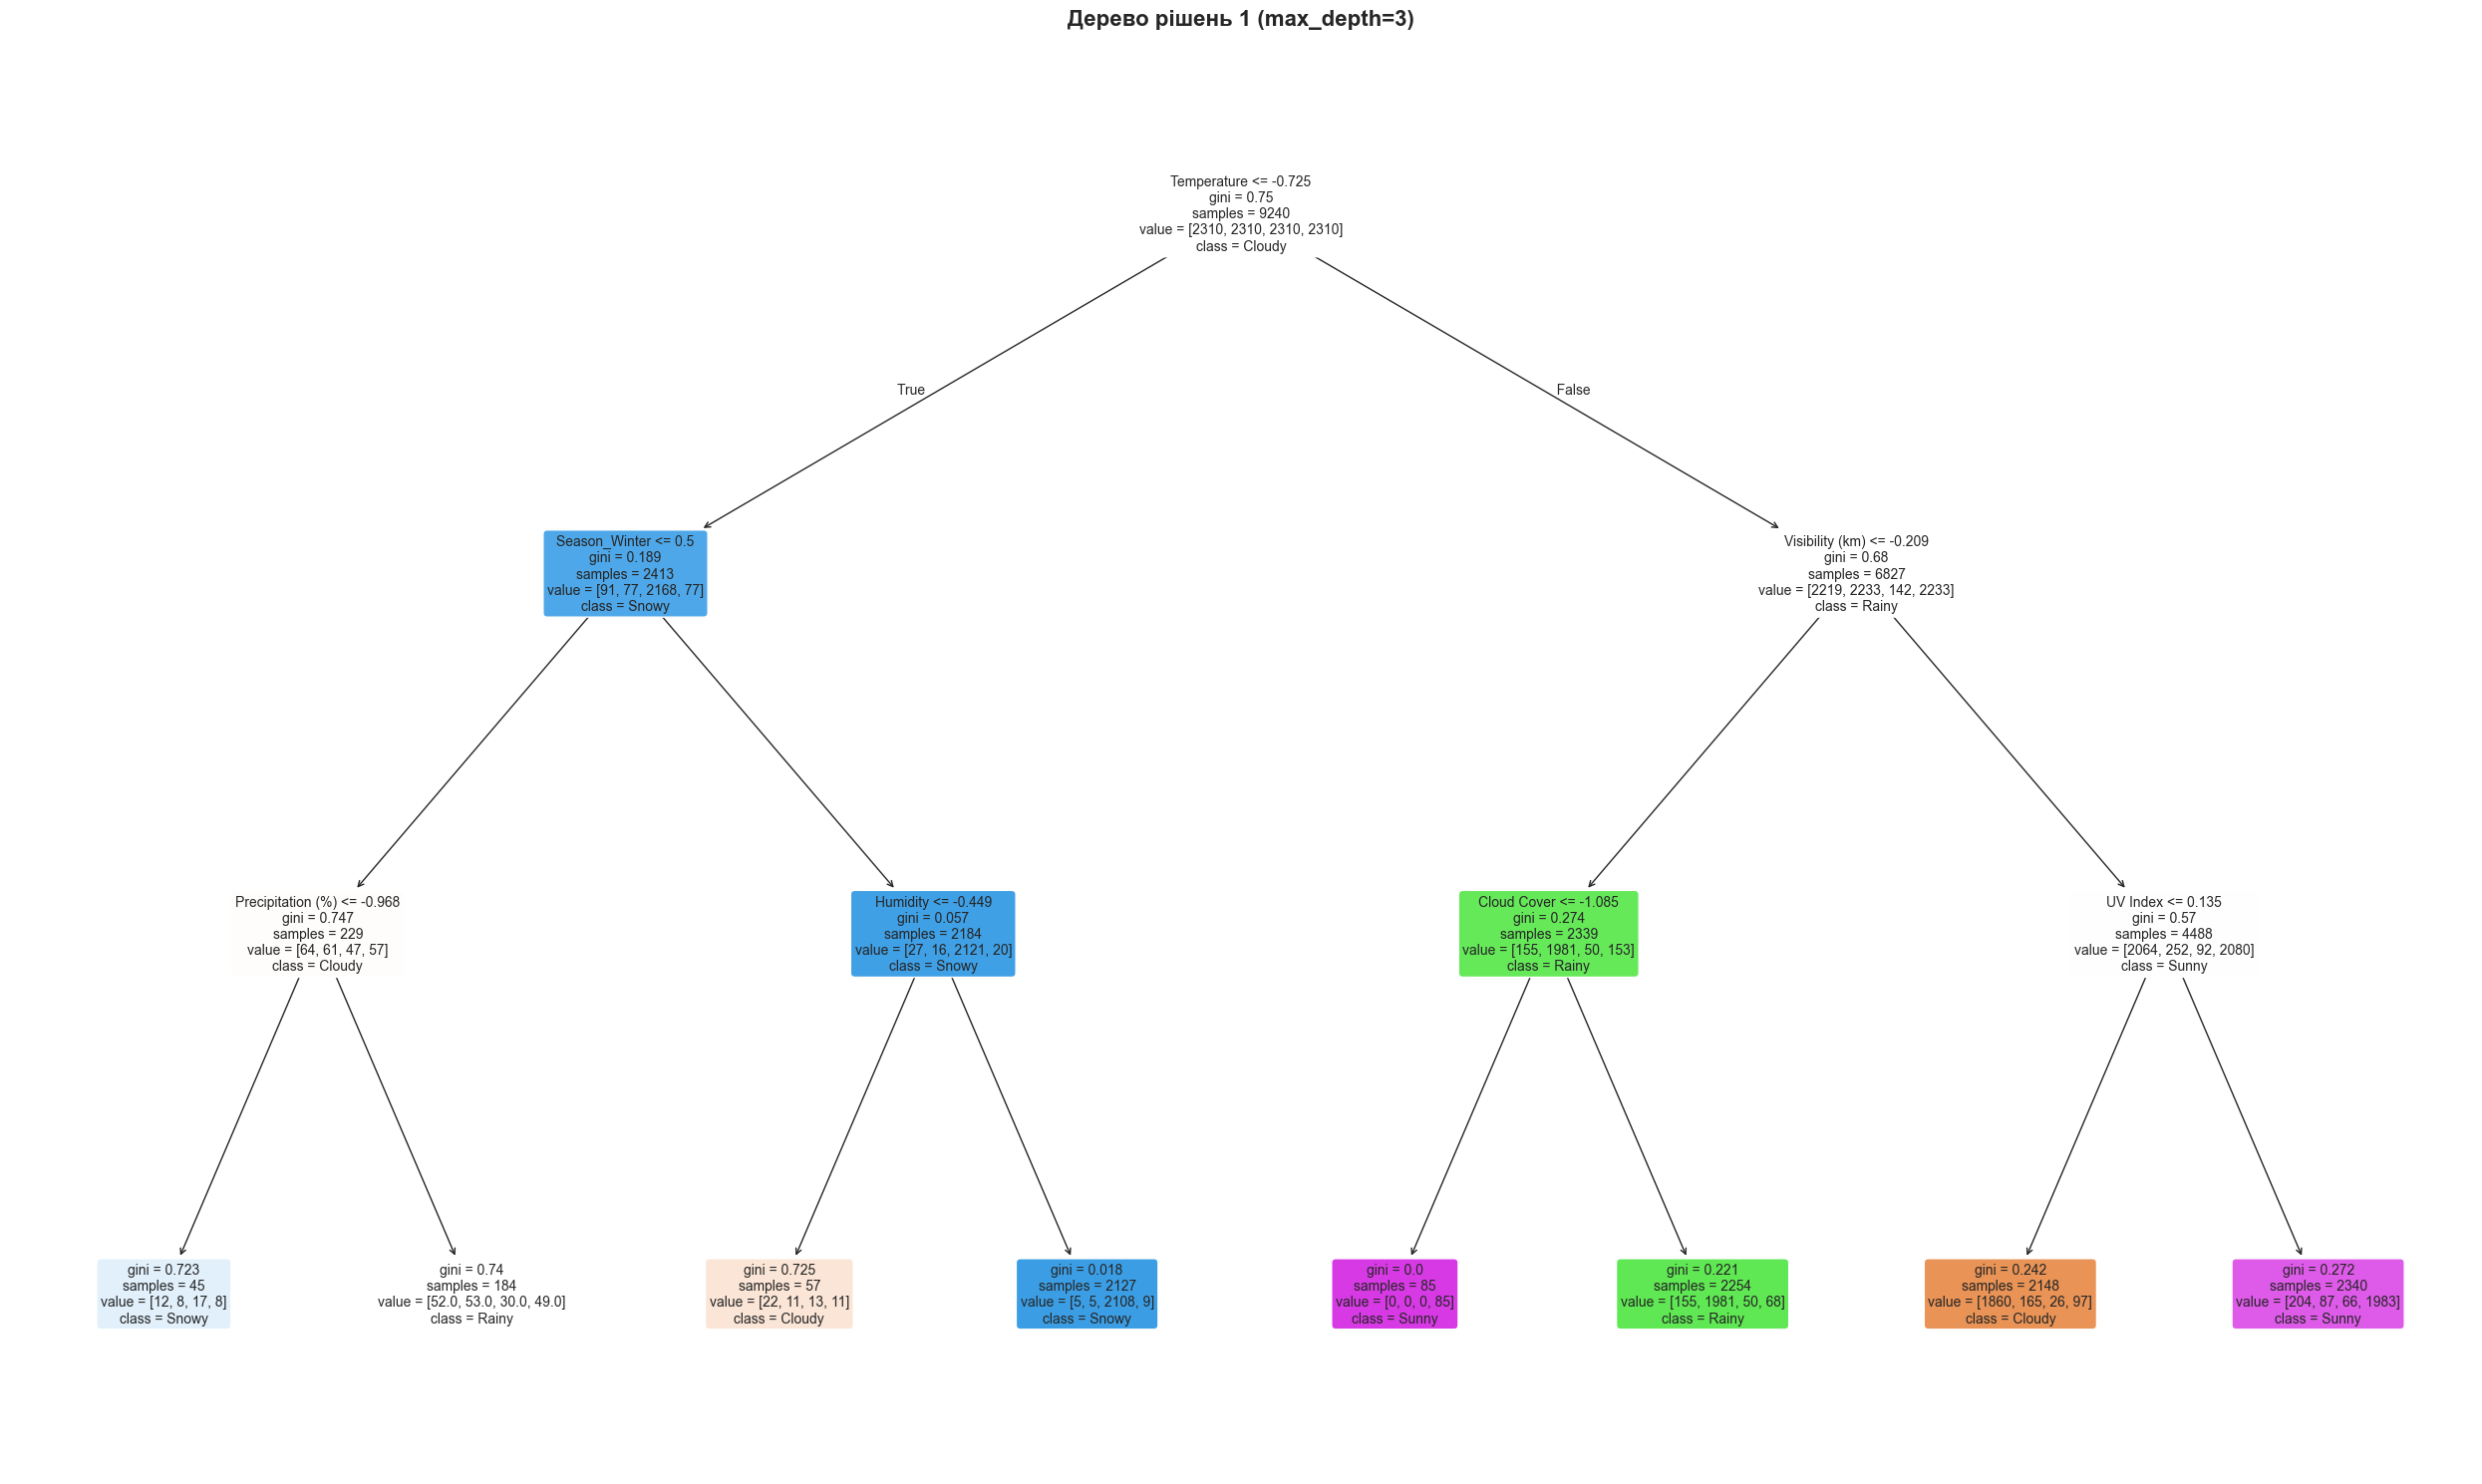

In [121]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Візуалізація першого дерева (depth=3)
plt.figure(figsize=(25, 15))
plot_tree(results['Дерево 1 (depth=3)']['model'], 
          feature_names=X_train.columns,
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Дерево рішень 1 (max_depth=3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

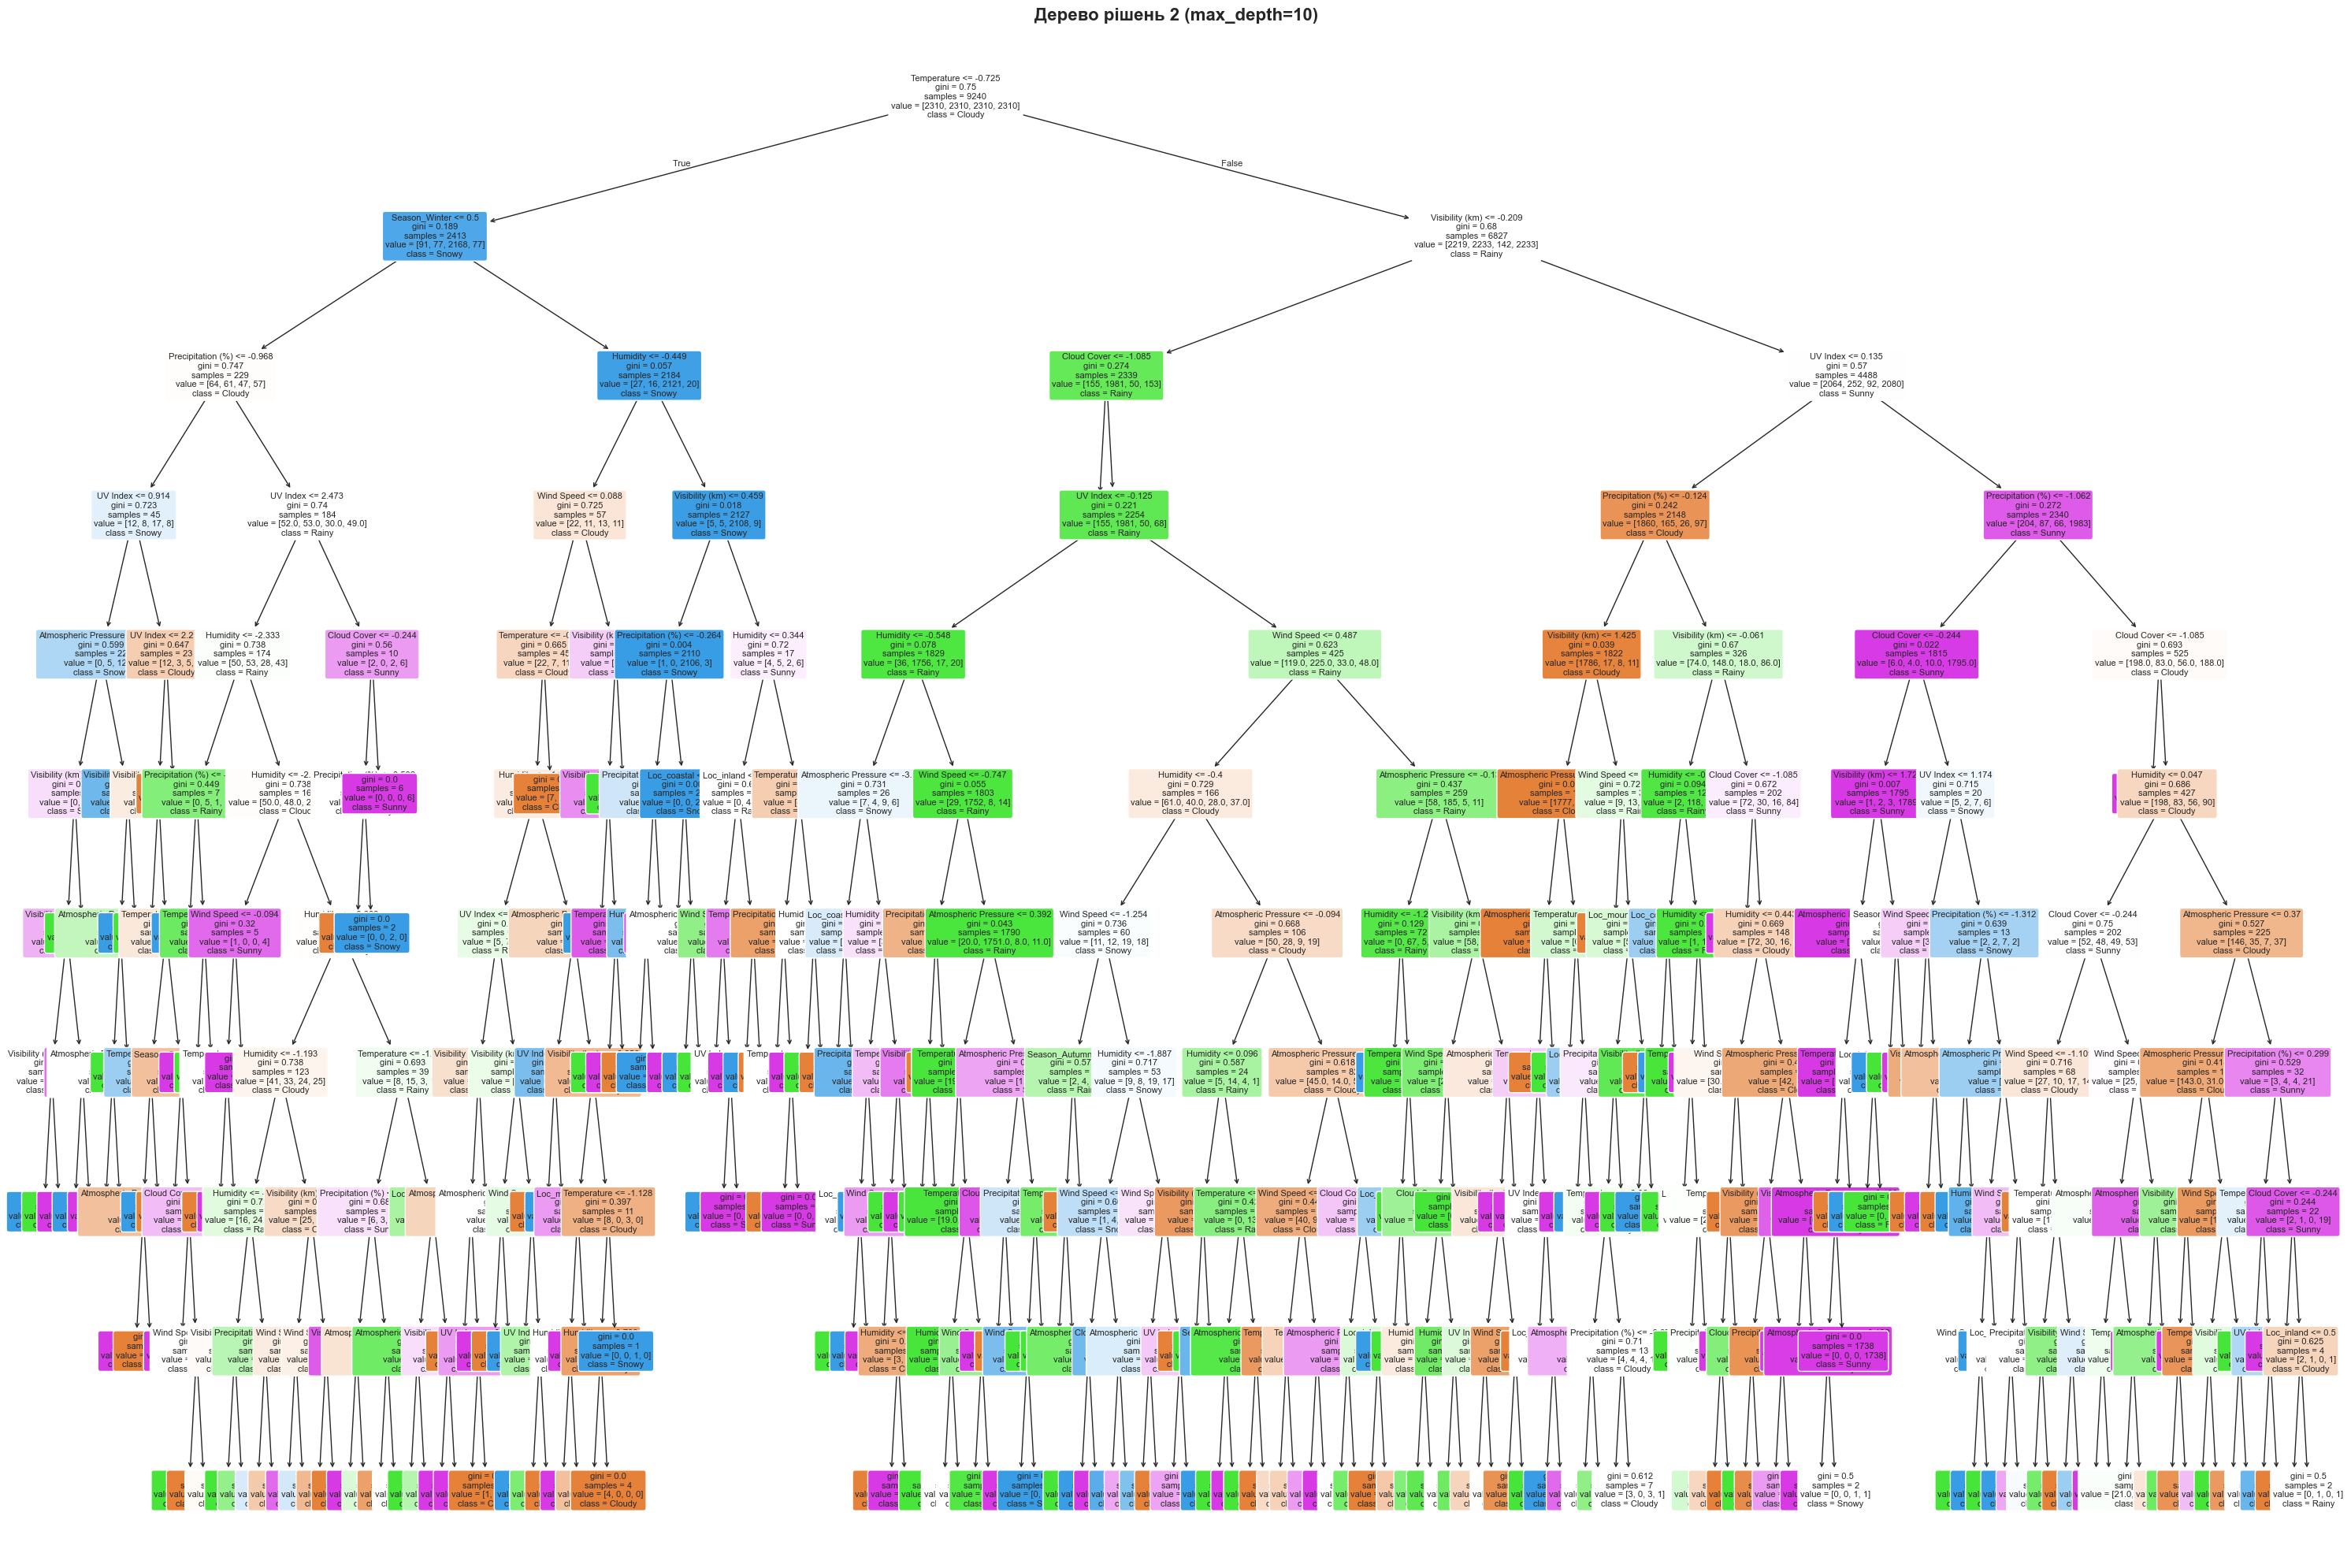

In [122]:
# Візуалізація другого дерева (depth=10)
plt.figure(figsize=(30, 20))
plot_tree(results['Дерево 2 (depth=10)']['model'], 
          feature_names=X_train.columns,
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=8)
plt.title('Дерево рішень 2 (max_depth=10)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

⚠️ УВАГА: Дерево без обмежень дуже велике!
Фактична глибина: 20
Кількість листків: 521

Візуалізуємо тільки перші 4 рівні для наочності...


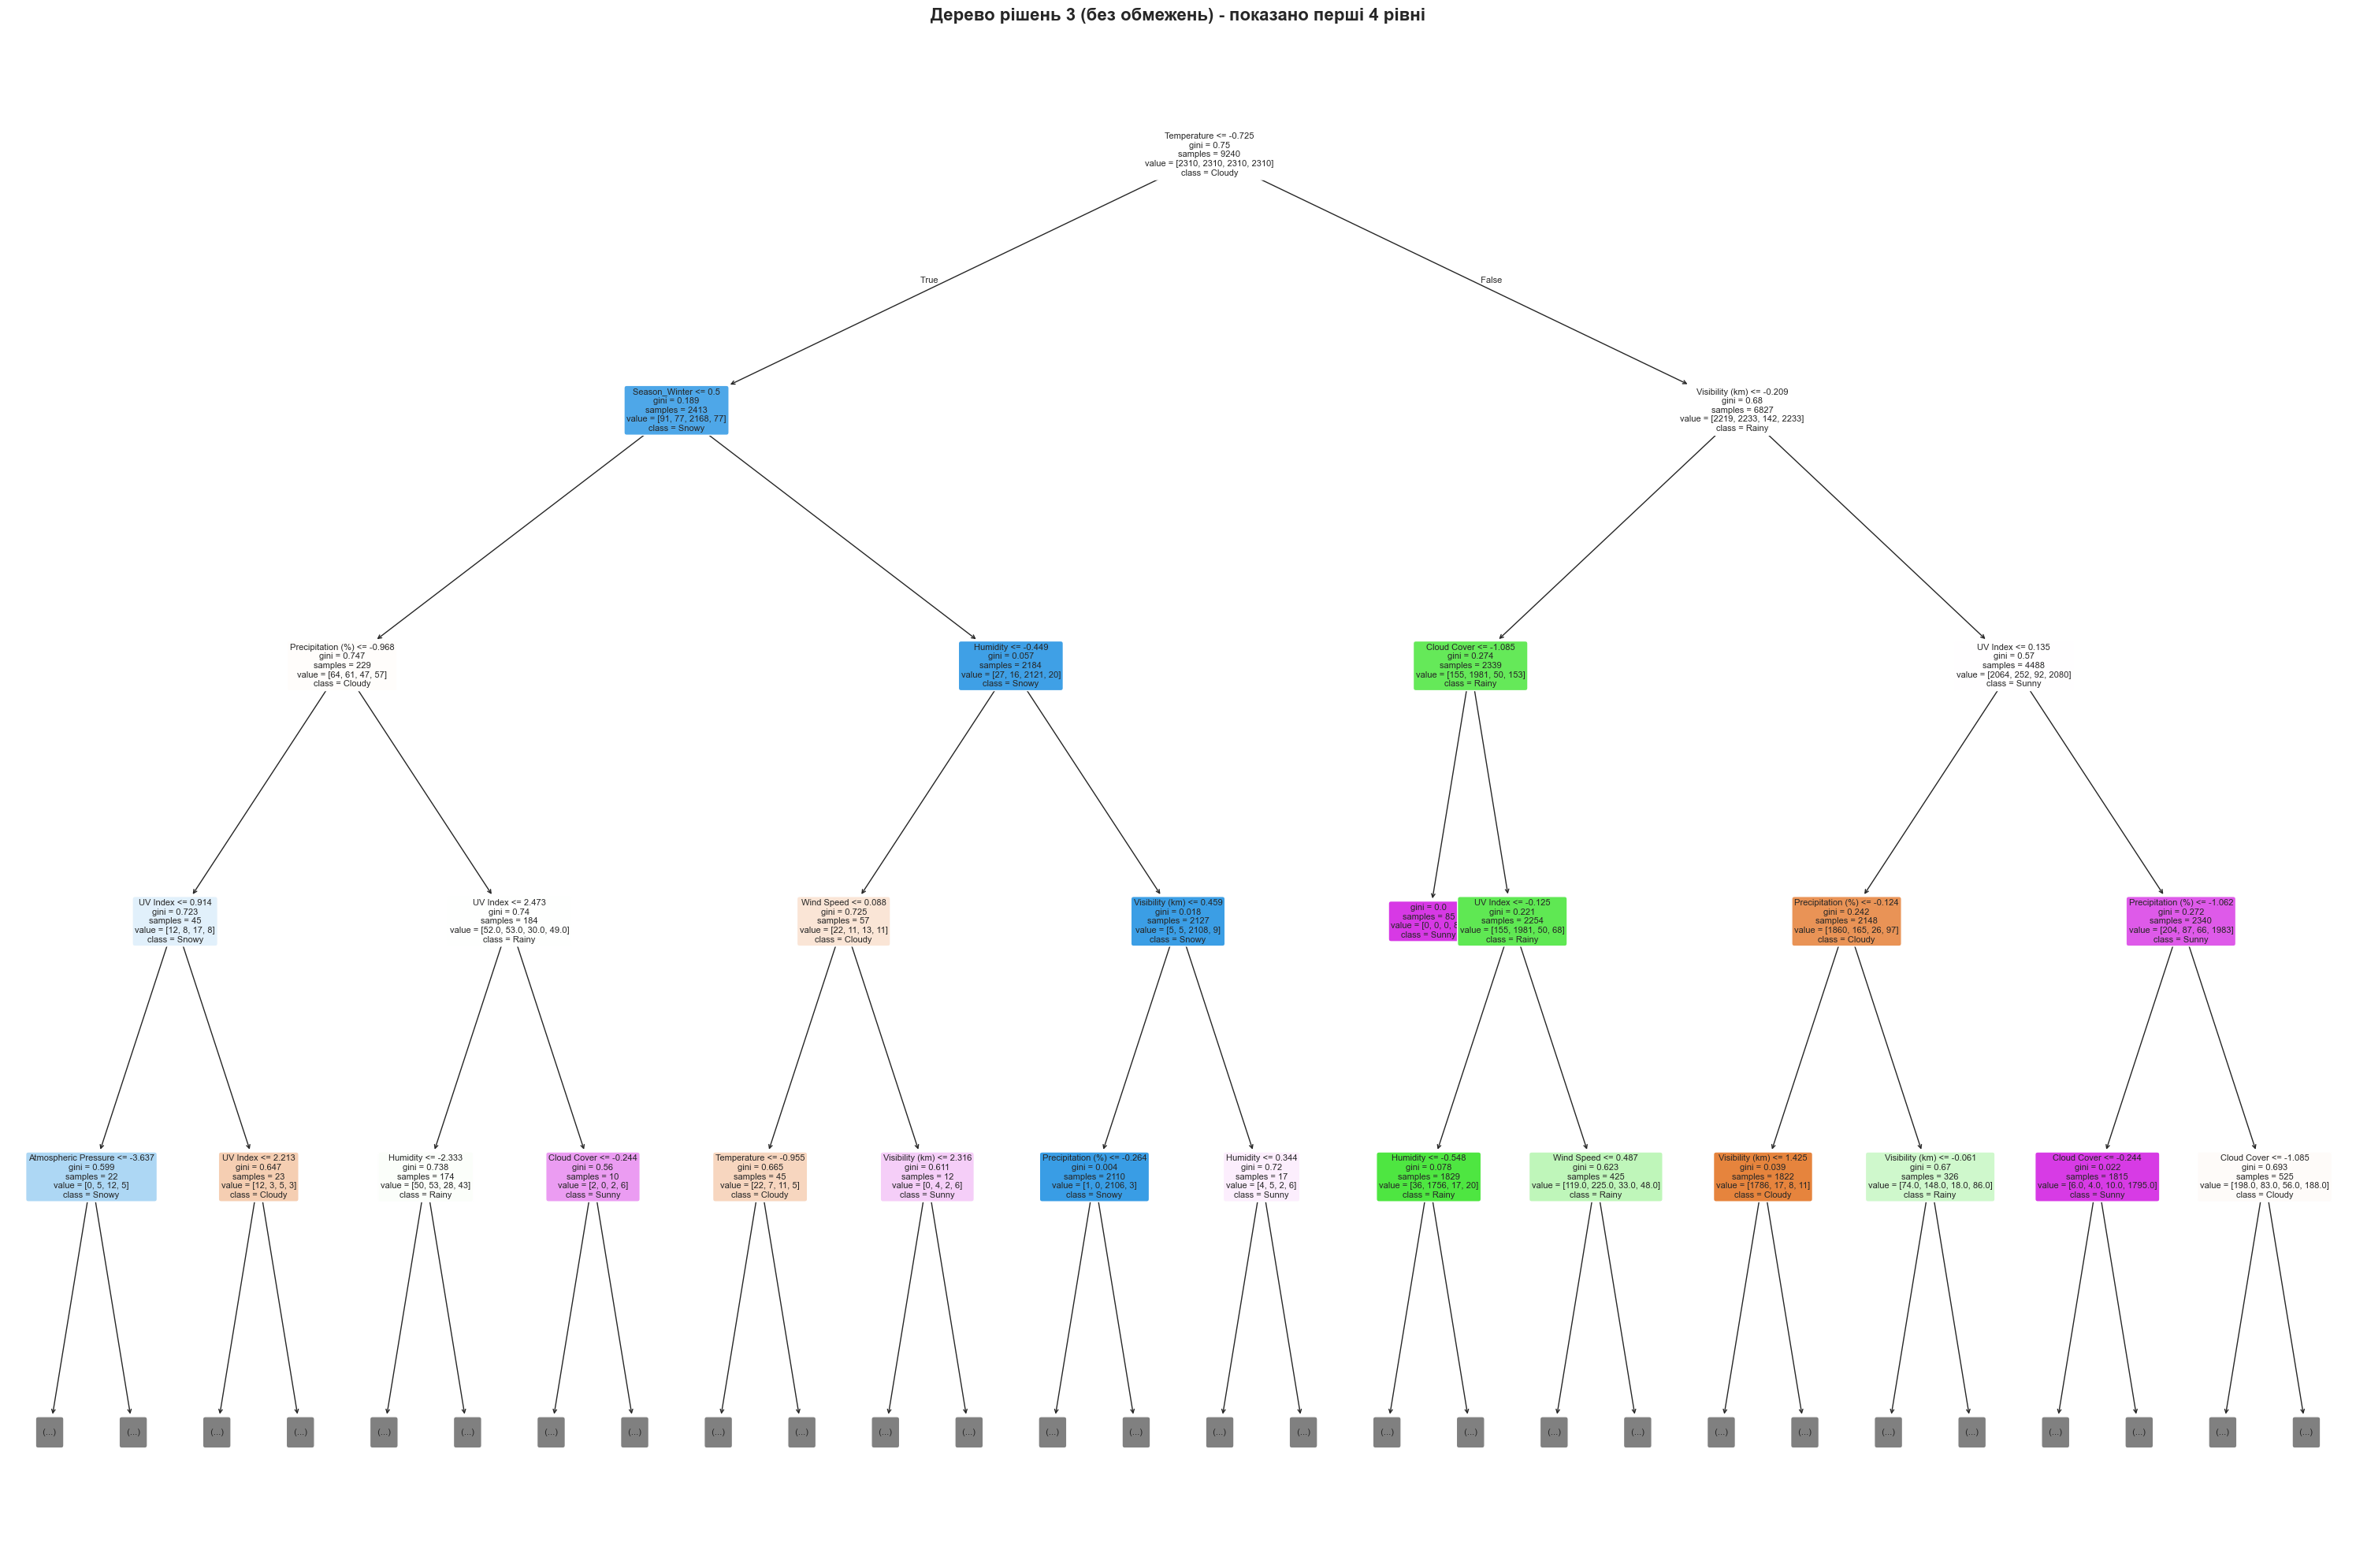

In [123]:
# Дерево без обмежень може бути дуже великим, тому візуалізуємо тільки частину
print("⚠️ УВАГА: Дерево без обмежень дуже велике!")
print(f"Фактична глибина: {results['Дерево 3 (без обмежень)']['depth']}")
print(f"Кількість листків: {results['Дерево 3 (без обмежень)']['n_leaves']}")
print("\nВізуалізуємо тільки перші 4 рівні для наочності...")

plt.figure(figsize=(30, 20))
plot_tree(results['Дерево 3 (без обмежень)']['model'], 
          feature_names=X_train.columns,
          class_names=sorted(y_train.unique()),
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=4)  # Обмежуємо візуалізацію
plt.title('Дерево рішень 3 (без обмежень) - показано перші 4 рівні', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Частина 3. Зашумлення даних

Додамо до тренувальних даних випадковий шум з рівномірним розподілом uniform[-0.1, 0.1] для кожної ознаки.
Побудуємо 3 дерева рішень на зашумлених даних і порівняємо з оригінальними результатами.

In [124]:
# Додамо шум до тренувальних даних
# Використовуємо uniform розподіл в межах [-0.1, 0.1]
# ВАЖЛИВО: Шум додаємо ТІЛЬКИ до числових ознак, НЕ до one-hot encoded!

np.random.seed(42)  # Для відтворюваності результатів

# Створюємо копію тренувальних даних
X_train_noisy = X_train.copy()

# Визначаємо числові ознаки (виключаємо one-hot encoded колонки)
numeric_cols = [col for col in X_train.columns 
                if not col.startswith('Season_') and not col.startswith('Loc_')]
categorical_cols = [col for col in X_train.columns 
                    if col.startswith('Season_') or col.startswith('Loc_')]

print("=== ДОДАВАННЯ ШУМУ ДО ТРЕНУВАЛЬНИХ ДАНИХ ===\n")
print(f"Числові ознаки (до них додаємо шум): {len(numeric_cols)}")
print(f"  {numeric_cols}")
print(f"\nКатегоріальні ознаки (залишаємо без змін): {len(categorical_cols)}")
print(f"  {categorical_cols}")

# Додаємо шум ТІЛЬКИ до числових ознак
noise = np.random.uniform(-0.5, 0.5, size=(X_train_noisy.shape[0], len(numeric_cols)))
X_train_noisy[numeric_cols] = X_train_noisy[numeric_cols] + noise

print(f"\nДіапазон шуму: uniform[-0.5, 0.5]")
print(f"Форма оригінальних даних: {X_train.shape}")
print(f"Форма зашумлених даних: {X_train_noisy.shape}")

# Порівняємо оригінальні та зашумлені дані
print("\n=== ПРИКЛАД ЗАШУМЛЕННЯ (перші 3 рядки, перші 5 числових ознак) ===\n")
print("ОРИГІНАЛЬНІ ДАНІ:")
print(X_train[numeric_cols].iloc[:3, :5])
print("\nЗАШУМЛЕНІ ДАНІ:")
print(X_train_noisy[numeric_cols].iloc[:3, :5])
print("\nДОДАНИЙ ШУМ:")
print((X_train_noisy[numeric_cols] - X_train[numeric_cols]).iloc[:3, :5])

# Перевіримо що one-hot колонки залишились без змін
print("\n=== ПЕРЕВІРКА: One-hot колонки не змінились ===")
print(f"Чи рівні one-hot колонки? {X_train[categorical_cols].equals(X_train_noisy[categorical_cols])}")

=== ДОДАВАННЯ ШУМУ ДО ТРЕНУВАЛЬНИХ ДАНИХ ===

Числові ознаки (до них додаємо шум): 8
  ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']

Категоріальні ознаки (залишаємо без змін): 7
  ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Loc_coastal', 'Loc_inland', 'Loc_mountain']

Діапазон шуму: uniform[-0.5, 0.5]
Форма оригінальних даних: (9240, 15)
Форма зашумлених даних: (9240, 15)

=== ПРИКЛАД ЗАШУМЛЕННЯ (перші 3 рядки, перші 5 числових ознак) ===

ОРИГІНАЛЬНІ ДАНІ:
       Temperature  Humidity  Wind Speed  Precipitation (%)  Cloud Cover
2107     -0.466726 -0.027705   -0.927871          -0.702365    -0.664689
12782    -1.214194  1.509073    3.134656           1.111902     1.017515
7581      0.510733 -0.077279   -1.000416          -1.327974    -0.664689

ЗАШУМЛЕНІ ДАНІ:
       Temperature  Humidity  Wind Speed  Precipitation (%)  Cloud Cover
2107     -0.592186  0.423009   -0.695877  

In [125]:
# Навчимо дерева на зашумлених даних
trees_noisy = {
    'Дерево 1 (depth=3, noisy)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Дерево 2 (depth=10, noisy)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Дерево 3 (без обмежень, noisy)': DecisionTreeClassifier(random_state=42)
}

# Навчимо моделі на зашумлених даних
results_noisy = {}

print("=" * 80)
print("НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗАШУМЛЕНИХ ДАНИХ")
print("=" * 80)

for name, model in trees_noisy.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Вимірюємо час навчання
    start_time = time.time()
    model.fit(X_train_noisy, y_train)
    training_time = time.time() - start_time
    
    # Передбачення на зашумлених тренувальних та валідаційних вибірках
    y_train_pred = model.predict(X_train_noisy)
    y_val_pred = model.predict(X_val)  # Валідація БЕЗ шуму!
    
    # Обчислюємо точність
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Зберігаємо результати
    results_noisy[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': training_time,
        'depth': model.get_depth(),
        'n_leaves': model.get_n_leaves()
    }
    
    print(f"  Час навчання: {training_time:.4f} сек")
    print(f"  Фактична глибина дерева: {model.get_depth()}")
    print(f"  Кількість листків: {model.get_n_leaves()}")
    print(f"  Точність на тренувальній вибірці (зашумленій): {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Точність на валідаційній вибірці: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"  Різниця (overfitting): {(train_accuracy - val_accuracy)*100:.2f}%")

print("\n" + "=" * 80)

НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗАШУМЛЕНИХ ДАНИХ

Дерево 1 (depth=3, noisy)
--------------------------------------------------------------------------------
  Час навчання: 0.0481 сек
  Фактична глибина дерева: 3
  Кількість листків: 8
  Точність на тренувальній вибірці (зашумленій): 0.7693 (76.93%)
  Точність на валідаційній вибірці: 0.8278 (82.78%)
  Різниця (overfitting): -5.85%

Дерево 2 (depth=10, noisy)
--------------------------------------------------------------------------------
  Час навчання: 0.0862 сек
  Фактична глибина дерева: 10
  Кількість листків: 286
  Точність на тренувальній вибірці (зашумленій): 0.9389 (93.89%)
  Точність на валідаційній вибірці: 0.9056 (90.56%)
  Різниця (overfitting): 3.33%

Дерево 3 (без обмежень, noisy)
--------------------------------------------------------------------------------
  Час навчання: 0.1230 сек
  Фактична глибина дерева: 27
  Кількість листків: 754
  Точність на тренувальній вибірці (зашумленій): 1.0000 (100.00%)
  Точність на валідаці

In [126]:
# Порівняльна таблиця: оригінальні vs зашумлені дані
print("=" * 100)
print("ПОРІВНЯННЯ РЕЗУЛЬТАТІВ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ ДАНІ")
print("=" * 100)

comparison_data_full = []

# Додаємо результати оригінальних дерев
for name, res in results.items():
    depth_str = name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None'
    comparison_data_full.append({
        'Тип даних': 'Оригінальні',
        'Max Depth': depth_str,
        'Фактична глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfitting': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

# Додаємо результати зашумлених дерев
for name, res in results_noisy.items():
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    comparison_data_full.append({
        'Тип даних': 'Зашумлені',
        'Max Depth': depth_str,
        'Фактична глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfitting': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

comparison_full_df = pd.DataFrame(comparison_data_full)
print("\n")
print(comparison_full_df.to_string(index=False))

ПОРІВНЯННЯ РЕЗУЛЬТАТІВ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ ДАНІ


  Тип даних Max Depth  Фактична глибина  Листків Train Acc Val Acc Overfitting
Оригінальні         3                 3        8    0.8776  0.8737       0.39%
Оригінальні        10                10      220    0.9588  0.9096       4.92%
Оригінальні      None                20      521    1.0000  0.9101       8.99%
  Зашумлені         3                 3        8    0.7693  0.8278      -5.85%
  Зашумлені        10                10      286    0.9389  0.9056       3.33%
  Зашумлені      None                27      754    1.0000  0.9030       9.70%


## Частина 4. PCA аналіз та знешумлення

Обрахуємо PCA на оригінальних та зашумлених даних, візуалізуємо компоненти, та використаємо PCA для знешумлення даних.

In [127]:
from sklearn.decomposition import PCA

# 1. PCA на оригінальних даних
pca_original = PCA()
pca_original.fit(X_train)

# 2. PCA на зашумлених даних
pca_noisy = PCA()
pca_noisy.fit(X_train_noisy)

print("=" * 80)
print("PCA АНАЛІЗ")
print("=" * 80)

print("\n=== ОРИГІНАЛЬНІ ДАНІ ===")
print(f"Кількість компонент: {pca_original.n_components_}")
print(f"Пояснена variance (перші 5 компонент): {pca_original.explained_variance_ratio_[:5]}")
print(f"Сумарна variance (всі компоненти): {pca_original.explained_variance_ratio_.sum():.4f}")

print("\n=== ЗАШУМЛЕНІ ДАНІ ===")
print(f"Кількість компонент: {pca_noisy.n_components_}")
print(f"Пояснена variance (перші 5 компонент): {pca_noisy.explained_variance_ratio_[:5]}")
print(f"Сумарна variance (всі компоненти): {pca_noisy.explained_variance_ratio_.sum():.4f}")

# Знайдемо кількість компонент для 95% variance
cumsum_original = np.cumsum(pca_original.explained_variance_ratio_)
cumsum_noisy = np.cumsum(pca_noisy.explained_variance_ratio_)

n_components_95_original = np.argmax(cumsum_original >= 0.95) + 1
n_components_95_noisy = np.argmax(cumsum_noisy >= 0.95) + 1

print("\n=== КОМПОНЕНТИ ДЛЯ 95% VARIANCE ===")
print(f"Оригінальні дані: {n_components_95_original} компонент")
print(f"Зашумлені дані: {n_components_95_noisy} компонент")

PCA АНАЛІЗ

=== ОРИГІНАЛЬНІ ДАНІ ===
Кількість компонент: 15
Пояснена variance (перші 5 компонент): [0.35133343 0.13257518 0.09743933 0.07516244 0.06476401]
Сумарна variance (всі компоненти): 1.0000

=== ЗАШУМЛЕНІ ДАНІ ===
Кількість компонент: 15
Пояснена variance (перші 5 компонент): [0.3358147  0.13167785 0.0987362  0.07824949 0.06839702]
Сумарна variance (всі компоненти): 1.0000

=== КОМПОНЕНТИ ДЛЯ 95% VARIANCE ===
Оригінальні дані: 11 компонент
Зашумлені дані: 11 компонент


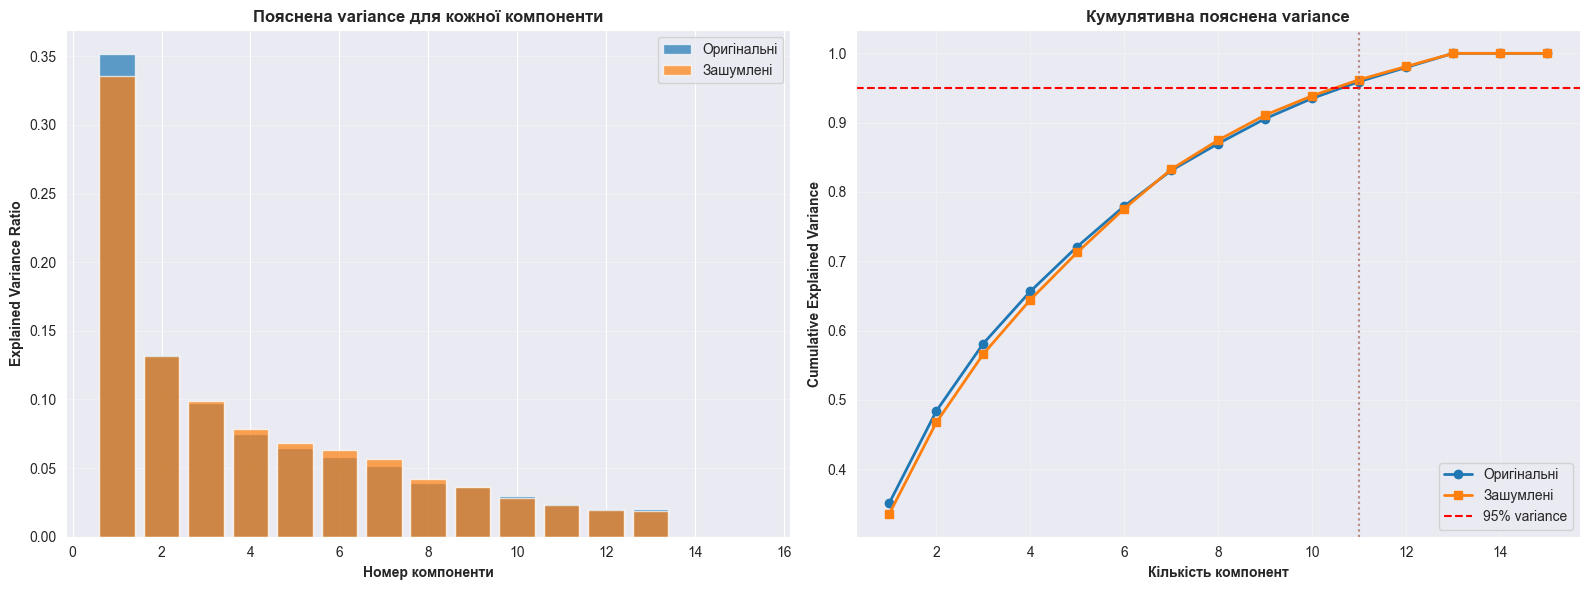


Для 95% variance потрібно:
  Оригінальні дані: 11 компонент
  Зашумлені дані: 11 компонент


In [128]:
# Візуалізація поясненої variance для обох PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік 1: Explained variance ratio
axes[0].bar(range(1, len(pca_original.explained_variance_ratio_) + 1), 
            pca_original.explained_variance_ratio_, 
            alpha=0.7, label='Оригінальні')
axes[0].bar(range(1, len(pca_noisy.explained_variance_ratio_) + 1), 
            pca_noisy.explained_variance_ratio_, 
            alpha=0.7, label='Зашумлені')
axes[0].set_xlabel('Номер компоненти', fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontweight='bold')
axes[0].set_title('Пояснена variance для кожної компоненти', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Графік 2: Cumulative explained variance
axes[1].plot(range(1, len(cumsum_original) + 1), cumsum_original, 
             'o-', label='Оригінальні', linewidth=2)
axes[1].plot(range(1, len(cumsum_noisy) + 1), cumsum_noisy, 
             's-', label='Зашумлені', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].axvline(x=n_components_95_original, color='blue', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_95_noisy, color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Кількість компонент', fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontweight='bold')
axes[1].set_title('Кумулятивна пояснена variance', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nДля 95% variance потрібно:")
print(f"  Оригінальні дані: {n_components_95_original} компонент")
print(f"  Зашумлені дані: {n_components_95_noisy} компонент")

In [129]:
# Реконструкція даних використовуючи PCA для знешумлення
# Використовуємо компоненти що пояснюють 95% variance

# Створюємо PCA з обмеженою кількістю компонент
pca_denoising = PCA(n_components=n_components_95_noisy)
pca_denoising.fit(X_train_noisy)

# Трансформуємо зашумлені дані в простір головних компонент
X_train_pca = pca_denoising.transform(X_train_noisy)

# Реконструюємо дані назад (знешумлення)
X_train_denoised = pca_denoising.inverse_transform(X_train_pca)

# Конвертуємо назад в DataFrame
X_train_denoised = pd.DataFrame(X_train_denoised, 
                                 columns=X_train.columns, 
                                 index=X_train.index)

print("=" * 80)
print("ЗНЕШУМЛЕННЯ ДАНИХ ЗА ДОПОМОГОЮ PCA")
print("=" * 80)
print(f"\nВикористано компонент: {n_components_95_noisy}")
print(f"Пояснено variance: {pca_denoising.explained_variance_ratio_.sum():.4f} ({pca_denoising.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"\nФорма оригінальних даних: {X_train.shape}")
print(f"Форма зашумлених даних: {X_train_noisy.shape}")
print(f"Форма знешумлених даних: {X_train_denoised.shape}")

# Обчислимо помилку реконструкції
reconstruction_error = np.mean((X_train_noisy.values - X_train_denoised.values) ** 2)
print(f"\nПомилка реконструкції (MSE): {reconstruction_error:.6f}")

ЗНЕШУМЛЕННЯ ДАНИХ ЗА ДОПОМОГОЮ PCA

Використано компонент: 11
Пояснено variance: 0.9619 (96.19%)

Форма оригінальних даних: (9240, 15)
Форма зашумлених даних: (9240, 15)
Форма знешумлених даних: (9240, 15)

Помилка реконструкції (MSE): 0.025469


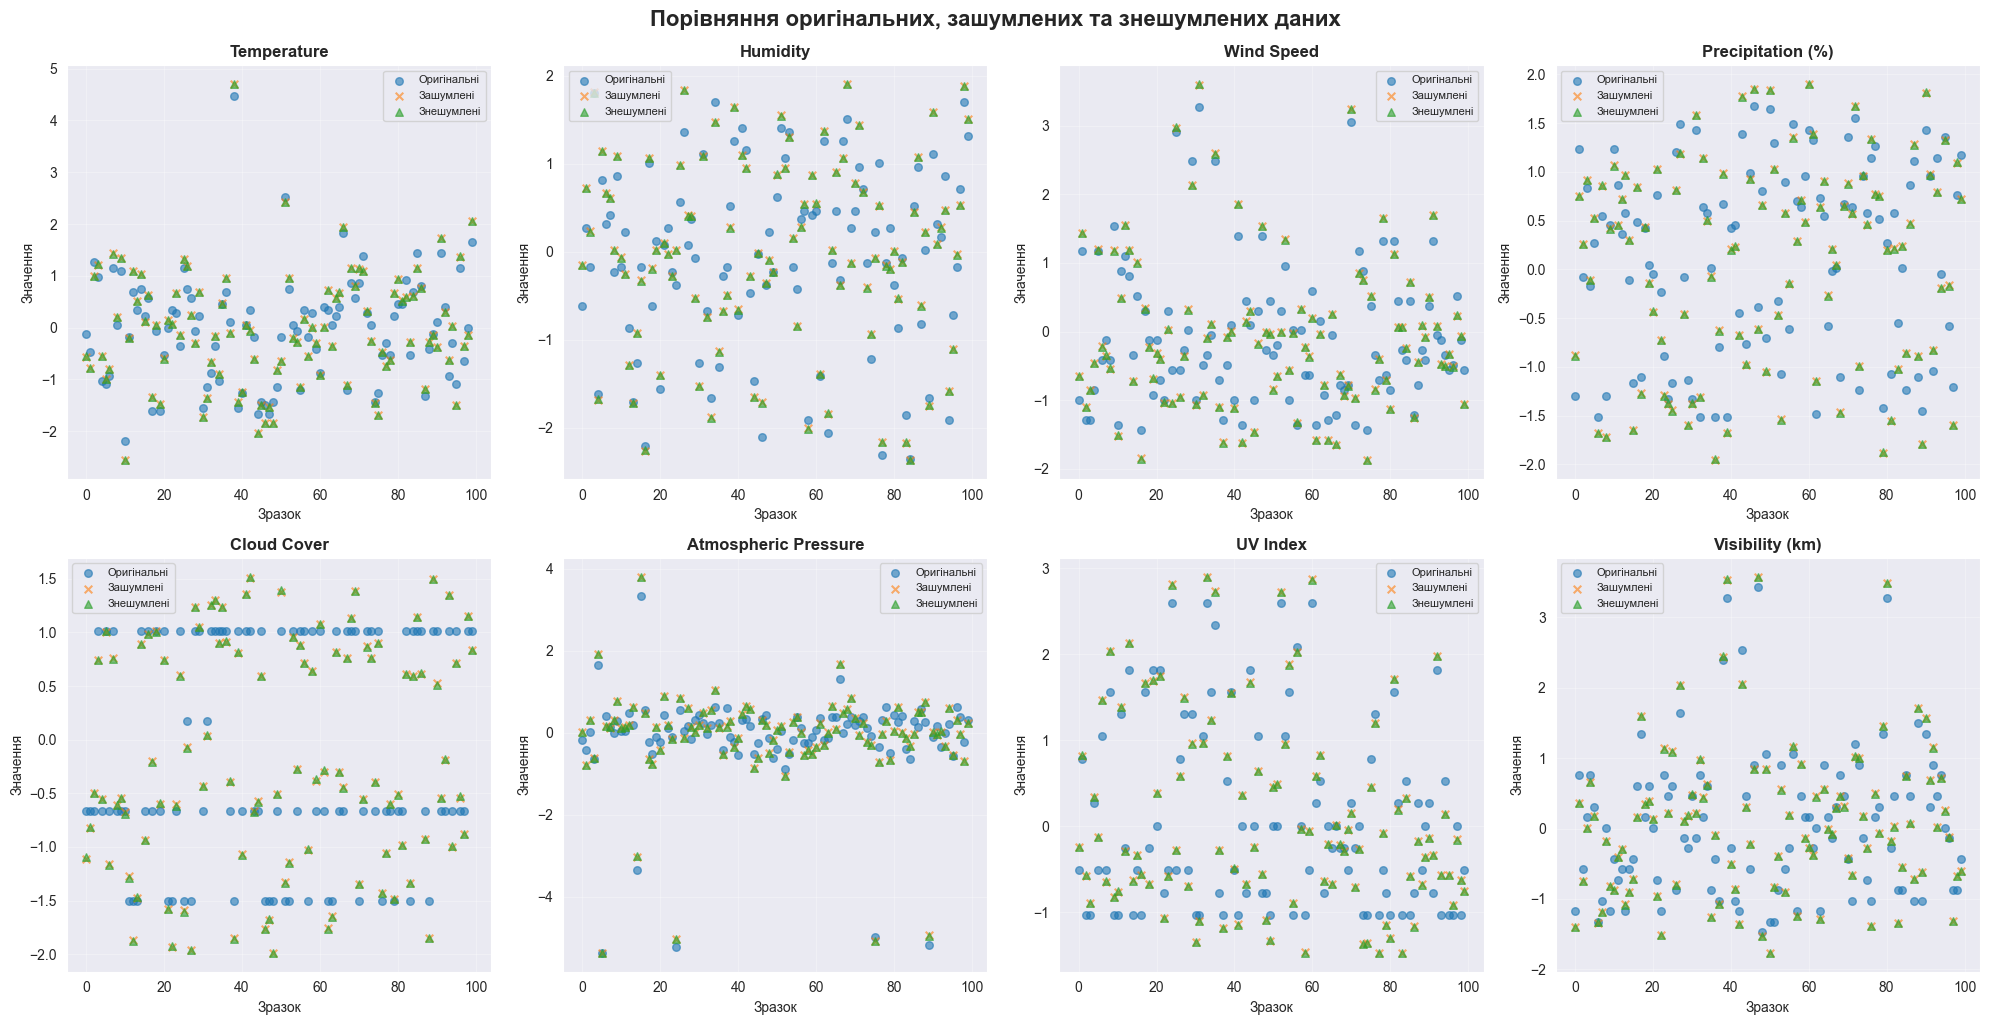

In [130]:
# Візуалізація порівняння оригінальних, зашумлених і знешумлених даних
# Візуалізуємо тільки числові ознаки

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Вибираємо 8 числових ознак для візуалізації
for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # Вибираємо випадкові 100 зразків для візуалізації
    sample_indices = np.random.choice(X_train.index, size=100, replace=False)
    
    ax.scatter(range(100), X_train.loc[sample_indices, col], 
               alpha=0.6, s=30, label='Оригінальні', marker='o')
    ax.scatter(range(100), X_train_noisy.loc[sample_indices, col], 
               alpha=0.6, s=30, label='Зашумлені', marker='x')
    ax.scatter(range(100), X_train_denoised.loc[sample_indices, col], 
               alpha=0.6, s=30, label='Знешумлені', marker='^')
    
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_xlabel('Зразок')
    ax.set_ylabel('Значення')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Порівняння оригінальних, зашумлених та знешумлених даних', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [131]:
# Обчислимо метрики якості знешумлення для числових ознак
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("=" * 80)
print("МЕТРИКИ ЯКОСТІ ЗНЕШУМЛЕННЯ (тільки для числових ознак)")
print("=" * 80)

results_denoising = []

for col in numeric_cols:
    
    # MSE між оригінальними та знешумленими
    mse_denoised = mean_squared_error(X_train[col], X_train_denoised[col])
    mae_denoised = mean_absolute_error(X_train[col], X_train_denoised[col])
    

    
    results_denoising.append({
        'Ознака': col,
        'MSE': f"{mse_denoised:.6f}",
        'MAE': f"{mae_denoised:.6f}",
    })

denoising_df = pd.DataFrame(results_denoising)
print("\n")
print(denoising_df.to_string(index=False))

# Загальна статистика
print("\n" + "=" * 80)
print("ЗАГАЛЬНА СТАТИСТИКА")
print("=" * 80)
total_mse_noisy = mean_squared_error(X_train[numeric_cols].values.flatten(),
                                      X_train_noisy[numeric_cols].values.flatten())
total_mse_denoised = mean_squared_error(X_train[numeric_cols].values.flatten(), 
                                         X_train_denoised[numeric_cols].values.flatten())
total_improvement = (total_mse_noisy - total_mse_denoised) / total_mse_noisy * 100

print(f"\nЗагальна MSE (зашумлені vs оригінальні): {total_mse_noisy:.6f}")
print(f"Загальна MSE (знешумлені vs оригінальні): {total_mse_denoised:.6f}")
print(f"Загальне покращення: {total_improvement:.2f}%")

МЕТРИКИ ЯКОСТІ ЗНЕШУМЛЕННЯ (тільки для числових ознак)


              Ознака      MSE      MAE
         Temperature 0.081762 0.247050
            Humidity 0.083022 0.249072
          Wind Speed 0.082825 0.248365
   Precipitation (%) 0.082945 0.249431
         Cloud Cover 0.083866 0.251421
Atmospheric Pressure 0.082572 0.249117
            UV Index 0.082645 0.249359
     Visibility (km) 0.084675 0.252175

ЗАГАЛЬНА СТАТИСТИКА

Загальна MSE (зашумлені vs оригінальні): 0.083016
Загальна MSE (знешумлені vs оригінальні): 0.083039
Загальне покращення: -0.03%


## Частина 5. Дерева рішень на знешумлених даних

Побудуємо дерева рішень на знешумлених даних (після PCA) та порівняємо їхню точність з деревами на оригінальних та зашумлених даних.

In [132]:
# Навчимо дерева на знешумлених даних
trees_denoised = {
    'Дерево 1 (depth=3, denoised)': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Дерево 2 (depth=10, denoised)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Дерево 3 (без обмежень, denoised)': DecisionTreeClassifier(random_state=42)
}

# Навчимо моделі на знешумлених даних
results_denoised = {}

print("=" * 80)
print("НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗНЕШУМЛЕНИХ ДАНИХ")
print("=" * 80)

for name, model in trees_denoised.items():
    print(f"\n{name}")
    print("-" * 80)
    
    # Вимірюємо час навчання
    start_time = time.time()
    model.fit(X_train_denoised, y_train)
    training_time = time.time() - start_time
    
    # Передбачення на знешумлених тренувальних та валідаційних вибірках
    y_train_pred = model.predict(X_train_denoised)
    y_val_pred = model.predict(X_val)  # Валідація на оригінальних даних
    
    # Обчислюємо точність
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Зберігаємо результати
    results_denoised[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': training_time,
        'depth': model.get_depth(),
        'n_leaves': model.get_n_leaves()
    }
    
    print(f"  Час навчання: {training_time:.4f} сек")
    print(f"  Фактична глибина дерева: {model.get_depth()}")
    print(f"  Кількість листків: {model.get_n_leaves()}")
    print(f"  Точність на тренувальній вибірці (знешумленій): {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Точність на валідаційній вибірці: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"  Різниця (overfitting): {(train_accuracy - val_accuracy)*100:.2f}%")

print("\n" + "=" * 80)

НАВЧАННЯ ДЕРЕВ РІШЕНЬ НА ЗНЕШУМЛЕНИХ ДАНИХ

Дерево 1 (depth=3, denoised)
--------------------------------------------------------------------------------
  Час навчання: 0.0592 сек
  Фактична глибина дерева: 3
  Кількість листків: 8
  Точність на тренувальній вибірці (знешумленій): 0.7671 (76.71%)
  Точність на валідаційній вибірці: 0.8273 (82.73%)
  Різниця (overfitting): -6.02%

Дерево 2 (depth=10, denoised)
--------------------------------------------------------------------------------
  Час навчання: 0.1467 сек
  Фактична глибина дерева: 10
  Кількість листків: 301
  Точність на тренувальній вибірці (знешумленій): 0.9384 (93.84%)
  Точність на валідаційній вибірці: 0.8884 (88.84%)
  Різниця (overfitting): 5.00%

Дерево 3 (без обмежень, denoised)
--------------------------------------------------------------------------------
  Час навчання: 0.2255 сек
  Фактична глибина дерева: 28
  Кількість листків: 739
  Точність на тренувальній вибірці (знешумленій): 1.0000 (100.00%)
  Точніст

In [133]:
# Повна порівняльна таблиця: оригінальні vs зашумлені vs знешумлені
print("=" * 120)
print("ПОВНЕ ПОРІВНЯННЯ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ vs ЗНЕШУМЛЕНІ ДАНІ")
print("=" * 120)

comparison_all = []

# Оригінальні дерева
for name, res in results.items():
    depth_str = name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None'
    comparison_all.append({
        'Тип даних': 'Оригінальні',
        'Max Depth': depth_str,
        'Глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfit': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

# Зашумлені дерева
for name, res in results_noisy.items():
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    comparison_all.append({
        'Тип даних': 'Зашумлені',
        'Max Depth': depth_str,
        'Глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfit': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

# Знешумлені дерева
for name, res in results_denoised.items():
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    comparison_all.append({
        'Тип даних': 'Знешумлені (PCA)',
        'Max Depth': depth_str,
        'Глибина': res['depth'],
        'Листків': res['n_leaves'],
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Overfit': f"{(res['train_accuracy'] - res['val_accuracy'])*100:.2f}%"
    })

comparison_all_df = pd.DataFrame(comparison_all)
print("\n")
print(comparison_all_df.to_string(index=False))

ПОВНЕ ПОРІВНЯННЯ: ОРИГІНАЛЬНІ vs ЗАШУМЛЕНІ vs ЗНЕШУМЛЕНІ ДАНІ


       Тип даних Max Depth  Глибина  Листків Train Acc Val Acc Overfit
     Оригінальні         3        3        8    0.8776  0.8737   0.39%
     Оригінальні        10       10      220    0.9588  0.9096   4.92%
     Оригінальні      None       20      521    1.0000  0.9101   8.99%
       Зашумлені         3        3        8    0.7693  0.8278  -5.85%
       Зашумлені        10       10      286    0.9389  0.9056   3.33%
       Зашумлені      None       27      754    1.0000  0.9030   9.70%
Знешумлені (PCA)         3        3        8    0.7671  0.8273  -6.02%
Знешумлені (PCA)        10       10      301    0.9384  0.8884   5.00%
Знешумлені (PCA)      None       28      739    1.0000  0.8424  15.76%


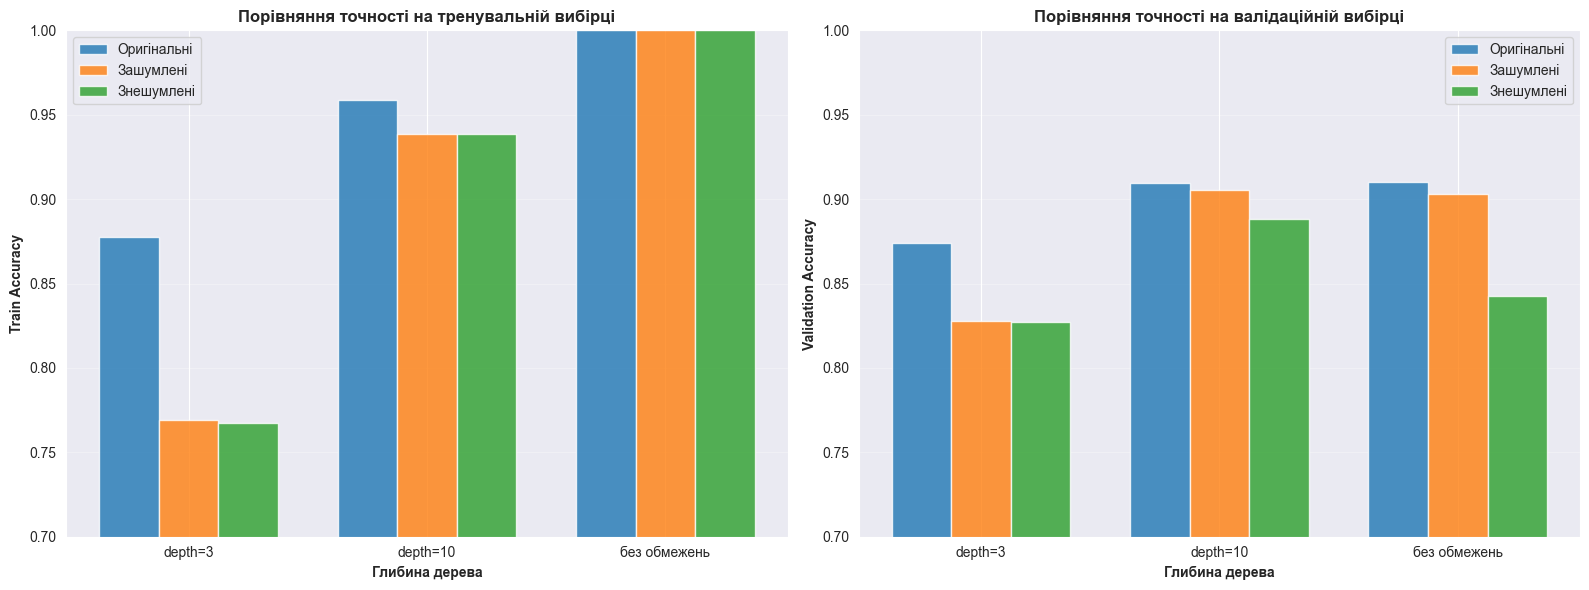

In [134]:
# Графік порівняння точності для всіх типів даних
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Підготовка даних
depths = ['depth=3', 'depth=10', 'без обмежень']
train_acc_original = [results['Дерево 1 (depth=3)']['train_accuracy'],
                      results['Дерево 2 (depth=10)']['train_accuracy'],
                      results['Дерево 3 (без обмежень)']['train_accuracy']]
val_acc_original = [results['Дерево 1 (depth=3)']['val_accuracy'],
                    results['Дерево 2 (depth=10)']['val_accuracy'],
                    results['Дерево 3 (без обмежень)']['val_accuracy']]

train_acc_noisy = [results_noisy['Дерево 1 (depth=3, noisy)']['train_accuracy'],
                   results_noisy['Дерево 2 (depth=10, noisy)']['train_accuracy'],
                   results_noisy['Дерево 3 (без обмежень, noisy)']['train_accuracy']]
val_acc_noisy = [results_noisy['Дерево 1 (depth=3, noisy)']['val_accuracy'],
                 results_noisy['Дерево 2 (depth=10, noisy)']['val_accuracy'],
                 results_noisy['Дерево 3 (без обмежень, noisy)']['val_accuracy']]

train_acc_denoised = [results_denoised['Дерево 1 (depth=3, denoised)']['train_accuracy'],
                      results_denoised['Дерево 2 (depth=10, denoised)']['train_accuracy'],
                      results_denoised['Дерево 3 (без обмежень, denoised)']['train_accuracy']]
val_acc_denoised = [results_denoised['Дерево 1 (depth=3, denoised)']['val_accuracy'],
                    results_denoised['Дерево 2 (depth=10, denoised)']['val_accuracy'],
                    results_denoised['Дерево 3 (без обмежень, denoised)']['val_accuracy']]

x = np.arange(len(depths))
width = 0.25

# Графік 1: Train Accuracy
axes[0].bar(x - width, train_acc_original, width, label='Оригінальні', alpha=0.8)
axes[0].bar(x, train_acc_noisy, width, label='Зашумлені', alpha=0.8)
axes[0].bar(x + width, train_acc_denoised, width, label='Знешумлені', alpha=0.8)
axes[0].set_xlabel('Глибина дерева', fontweight='bold')
axes[0].set_ylabel('Train Accuracy', fontweight='bold')
axes[0].set_title('Порівняння точності на тренувальній вибірці', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(depths)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Графік 2: Validation Accuracy
axes[1].bar(x - width, val_acc_original, width, label='Оригінальні', alpha=0.8)
axes[1].bar(x, val_acc_noisy, width, label='Зашумлені', alpha=0.8)
axes[1].bar(x + width, val_acc_denoised, width, label='Знешумлені', alpha=0.8)
axes[1].set_xlabel('Глибина дерева', fontweight='bold')
axes[1].set_ylabel('Validation Accuracy', fontweight='bold')
axes[1].set_title('Порівняння точності на валідаційній вибірці', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(depths)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.show()

In [135]:
# Аналіз впливу шуму та знешумлення на точність
print("=" * 80)
print("АНАЛІЗ ВПЛИВУ ШУМУ ТА ЗНЕШУМЛЕННЯ")
print("=" * 80)

for depth_name in ['depth=3', 'depth=10', 'без обмежень']:
    print(f"\n{'='*80}")
    print(f"  {depth_name.upper()}")
    print(f"{'='*80}")
    
    # Знаходимо відповідні моделі
    if depth_name == 'depth=3':
        orig = results['Дерево 1 (depth=3)']
        noisy = results_noisy['Дерево 1 (depth=3, noisy)']
        denoised = results_denoised['Дерево 1 (depth=3, denoised)']
    elif depth_name == 'depth=10':
        orig = results['Дерево 2 (depth=10)']
        noisy = results_noisy['Дерево 2 (depth=10, noisy)']
        denoised = results_denoised['Дерево 2 (depth=10, denoised)']
    else:
        orig = results['Дерево 3 (без обмежень)']
        noisy = results_noisy['Дерево 3 (без обмежень, noisy)']
        denoised = results_denoised['Дерево 3 (без обмежень, denoised)']
    
    # Валідаційна точність
    print(f"\nВАЛІДАЦІЙНА ТОЧНІСТЬ:")
    print(f"  Оригінальні дані:    {orig['val_accuracy']:.4f} ({orig['val_accuracy']*100:.2f}%)")
    print(f"  Зашумлені дані:      {noisy['val_accuracy']:.4f} ({noisy['val_accuracy']*100:.2f}%)")
    print(f"  Знешумлені дані:     {denoised['val_accuracy']:.4f} ({denoised['val_accuracy']*100:.2f}%)")
    
    # Зміни точності
    drop_from_noise = (orig['val_accuracy'] - noisy['val_accuracy']) * 100
    recovery_from_denoising = (denoised['val_accuracy'] - noisy['val_accuracy']) * 100
    final_difference = (denoised['val_accuracy'] - orig['val_accuracy']) * 100
    
    print(f"\nЗМІНИ ТОЧНОСТІ:")
    print(f"  Втрата від шуму:           {drop_from_noise:+.2f}% (оригінальні → зашумлені)")
    print(f"  Покращення від PCA:        {recovery_from_denoising:+.2f}% (зашумлені → знешумлені)")
    print(f"  Підсумкова різниця:        {final_difference:+.2f}% (оригінальні → знешумлені)")
    
    # Overfitting
    print(f"\nOVERFITTING:")
    overfit_orig = (orig['train_accuracy'] - orig['val_accuracy']) * 100
    overfit_noisy = (noisy['train_accuracy'] - noisy['val_accuracy']) * 100
    overfit_denoised = (denoised['train_accuracy'] - denoised['val_accuracy']) * 100
    
    print(f"  Оригінальні:   {overfit_orig:.2f}%")
    print(f"  Зашумлені:     {overfit_noisy:.2f}%")
    print(f"  Знешумлені:    {overfit_denoised:.2f}%")

print("\n" + "=" * 80)

АНАЛІЗ ВПЛИВУ ШУМУ ТА ЗНЕШУМЛЕННЯ

  DEPTH=3

ВАЛІДАЦІЙНА ТОЧНІСТЬ:
  Оригінальні дані:    0.8737 (87.37%)
  Зашумлені дані:      0.8278 (82.78%)
  Знешумлені дані:     0.8273 (82.73%)

ЗМІНИ ТОЧНОСТІ:
  Втрата від шуму:           +4.60% (оригінальні → зашумлені)
  Покращення від PCA:        -0.05% (зашумлені → знешумлені)
  Підсумкова різниця:        -4.65% (оригінальні → знешумлені)

OVERFITTING:
  Оригінальні:   0.39%
  Зашумлені:     -5.85%
  Знешумлені:    -6.02%

  DEPTH=10

ВАЛІДАЦІЙНА ТОЧНІСТЬ:
  Оригінальні дані:    0.9096 (90.96%)
  Зашумлені дані:      0.9056 (90.56%)
  Знешумлені дані:     0.8884 (88.84%)

ЗМІНИ ТОЧНОСТІ:
  Втрата від шуму:           +0.40% (оригінальні → зашумлені)
  Покращення від PCA:        -1.72% (зашумлені → знешумлені)
  Підсумкова різниця:        -2.12% (оригінальні → знешумлені)

OVERFITTING:
  Оригінальні:   4.92%
  Зашумлені:     3.33%
  Знешумлені:    5.00%

  БЕЗ ОБМЕЖЕНЬ

ВАЛІДАЦІЙНА ТОЧНІСТЬ:
  Оригінальні дані:    0.9101 (91.01%)
  Зашумлені

## Частина 6. Тестування на тестовому наборі даних

Оцінимо фінальну точність всіх моделей на тестовому наборі даних.

In [136]:
# Тестування всіх моделей на тестовому наборі
print("=" * 100)
print("ТЕСТУВАННЯ НА ТЕСТОВОМУ НАБОРІ ДАНИХ")
print("=" * 100)

test_results = []

# 1. Тестування оригінальних моделей
print("\n" + "="*100)
print("ОРИГІНАЛЬНІ МОДЕЛІ")
print("="*100)

for name, res in results.items():
    y_test_pred = res['model'].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    depth_str = name.split('depth=')[1].split(')')[0] if 'depth=' in name else 'None'
    
    test_results.append({
        'Тип даних': 'Оригінальні',
        'Модель': name,
        'Max Depth': depth_str,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Test Acc': f"{test_accuracy:.4f}",
        'Test Acc %': f"{test_accuracy*100:.2f}%"
    })
    
    print(f"\n{name}")
    print(f"  Train: {res['train_accuracy']:.4f}, Val: {res['val_accuracy']:.4f}, Test: {test_accuracy:.4f}")

# 2. Тестування зашумлених моделей
print("\n" + "="*100)
print("ЗАШУМЛЕНІ МОДЕЛІ")
print("="*100)

for name, res in results_noisy.items():
    y_test_pred = res['model'].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    
    test_results.append({
        'Тип даних': 'Зашумлені',
        'Модель': name,
        'Max Depth': depth_str,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Test Acc': f"{test_accuracy:.4f}",
        'Test Acc %': f"{test_accuracy*100:.2f}%"
    })
    
    print(f"\n{name}")
    print(f"  Train: {res['train_accuracy']:.4f}, Val: {res['val_accuracy']:.4f}, Test: {test_accuracy:.4f}")

# 3. Тестування знешумлених моделей
print("\n" + "="*100)
print("ЗНЕШУМЛЕНІ МОДЕЛІ (PCA)")
print("="*100)

for name, res in results_denoised.items():
    y_test_pred = res['model'].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    depth_str = name.split('depth=')[1].split(',')[0] if 'depth=' in name else 'None'
    
    test_results.append({
        'Тип даних': 'Знешумлені (PCA)',
        'Модель': name,
        'Max Depth': depth_str,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Val Acc': f"{res['val_accuracy']:.4f}",
        'Test Acc': f"{test_accuracy:.4f}",
        'Test Acc %': f"{test_accuracy*100:.2f}%"
    })
    
    print(f"\n{name}")
    print(f"  Train: {res['train_accuracy']:.4f}, Val: {res['val_accuracy']:.4f}, Test: {test_accuracy:.4f}")

print("\n" + "="*100)

ТЕСТУВАННЯ НА ТЕСТОВОМУ НАБОРІ ДАНИХ

ОРИГІНАЛЬНІ МОДЕЛІ

Дерево 1 (depth=3)
  Train: 0.8776, Val: 0.8737, Test: 0.8732

Дерево 2 (depth=10)
  Train: 0.9588, Val: 0.9096, Test: 0.9051

Дерево 3 (без обмежень)
  Train: 1.0000, Val: 0.9101, Test: 0.9035

ЗАШУМЛЕНІ МОДЕЛІ

Дерево 1 (depth=3, noisy)
  Train: 0.7693, Val: 0.8278, Test: 0.8258

Дерево 2 (depth=10, noisy)
  Train: 0.9389, Val: 0.9056, Test: 0.8960

Дерево 3 (без обмежень, noisy)
  Train: 1.0000, Val: 0.9030, Test: 0.8929

ЗНЕШУМЛЕНІ МОДЕЛІ (PCA)

Дерево 1 (depth=3, denoised)
  Train: 0.7671, Val: 0.8273, Test: 0.8253

Дерево 2 (depth=10, denoised)
  Train: 0.9384, Val: 0.8884, Test: 0.8773

Дерево 3 (без обмежень, denoised)
  Train: 1.0000, Val: 0.8424, Test: 0.8338



In [137]:
# Порівняльна таблиця з тестовими результатами
test_results_df = pd.DataFrame(test_results)

print("\n" + "=" * 120)
print("ФІНАЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ (TRAIN / VALIDATION / TEST)")
print("=" * 120)
print("\n")
print(test_results_df[['Тип даних', 'Max Depth', 'Train Acc', 'Val Acc', 'Test Acc']].to_string(index=False))


ФІНАЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ (TRAIN / VALIDATION / TEST)


       Тип даних Max Depth Train Acc Val Acc Test Acc
     Оригінальні         3    0.8776  0.8737   0.8732
     Оригінальні        10    0.9588  0.9096   0.9051
     Оригінальні      None    1.0000  0.9101   0.9035
       Зашумлені         3    0.7693  0.8278   0.8258
       Зашумлені        10    0.9389  0.9056   0.8960
       Зашумлені      None    1.0000  0.9030   0.8929
Знешумлені (PCA)         3    0.7671  0.8273   0.8253
Знешумлені (PCA)        10    0.9384  0.8884   0.8773
Знешумлені (PCA)      None    1.0000  0.8424   0.8338


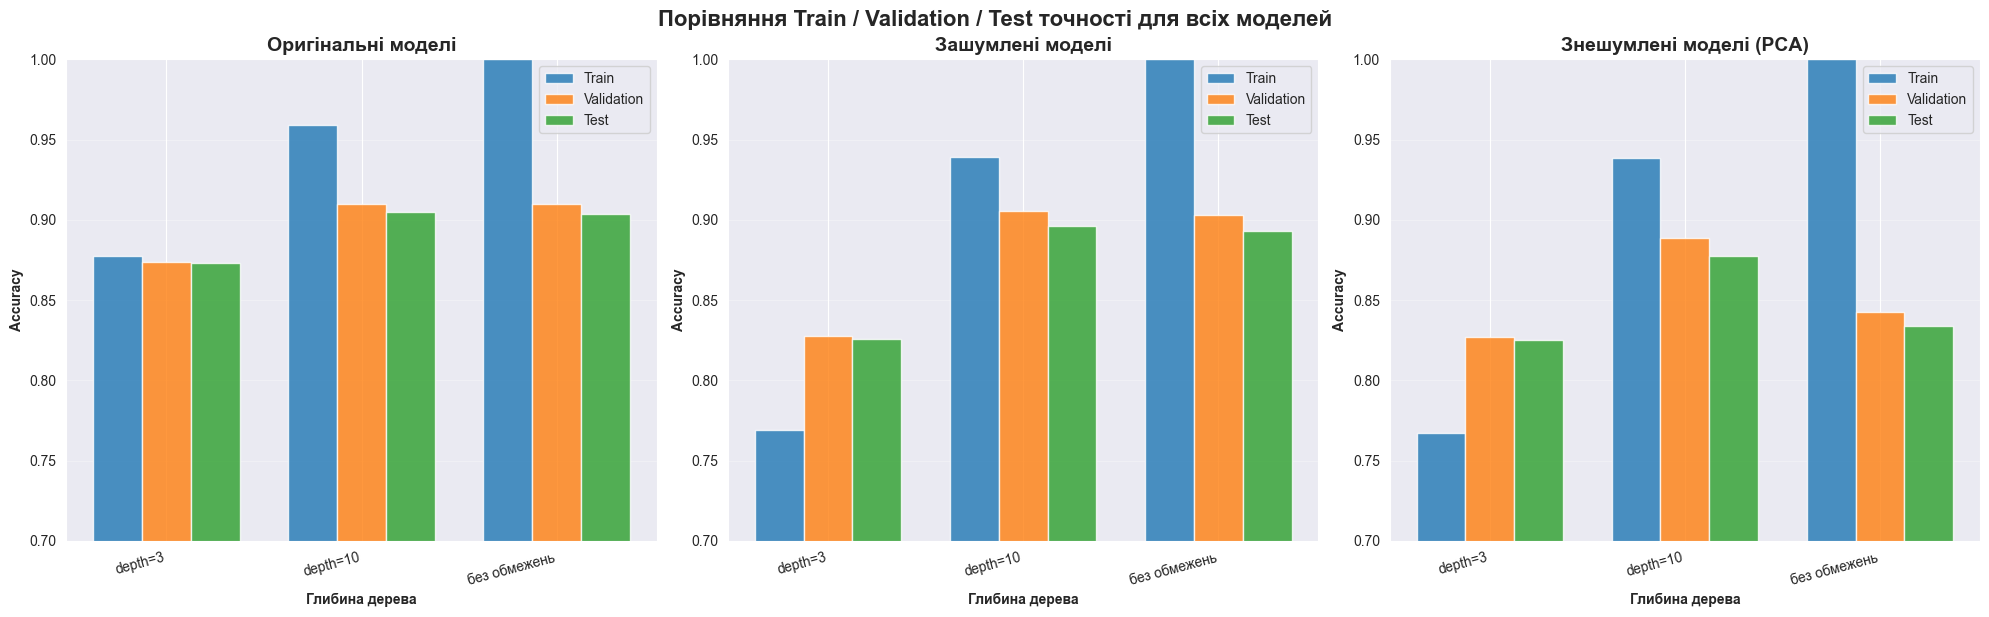

In [138]:
# Візуалізація тестових результатів
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

depths = ['depth=3', 'depth=10', 'без обмежень']

# Збираємо дані для графіків
train_orig = [float(test_results_df[(test_results_df['Тип даних'] == 'Оригінальні') & 
                                     (test_results_df['Max Depth'] == d)]['Train Acc'].values[0]) 
              for d in ['3', '10', 'None']]
val_orig = [float(test_results_df[(test_results_df['Тип даних'] == 'Оригінальні') & 
                                   (test_results_df['Max Depth'] == d)]['Val Acc'].values[0]) 
            for d in ['3', '10', 'None']]
test_orig = [float(test_results_df[(test_results_df['Тип даних'] == 'Оригінальні') & 
                                    (test_results_df['Max Depth'] == d)]['Test Acc'].values[0]) 
             for d in ['3', '10', 'None']]

train_noisy = [float(test_results_df[(test_results_df['Тип даних'] == 'Зашумлені') & 
                                      (test_results_df['Max Depth'] == d)]['Train Acc'].values[0]) 
               for d in ['3', '10', 'None']]
val_noisy = [float(test_results_df[(test_results_df['Тип даних'] == 'Зашумлені') & 
                                    (test_results_df['Max Depth'] == d)]['Val Acc'].values[0]) 
             for d in ['3', '10', 'None']]
test_noisy = [float(test_results_df[(test_results_df['Тип даних'] == 'Зашумлені') & 
                                     (test_results_df['Max Depth'] == d)]['Test Acc'].values[0]) 
              for d in ['3', '10', 'None']]

train_denoised = [float(test_results_df[(test_results_df['Тип даних'] == 'Знешумлені (PCA)') & 
                                         (test_results_df['Max Depth'] == d)]['Train Acc'].values[0]) 
                  for d in ['3', '10', 'None']]
val_denoised = [float(test_results_df[(test_results_df['Тип даних'] == 'Знешумлені (PCA)') & 
                                       (test_results_df['Max Depth'] == d)]['Val Acc'].values[0]) 
                for d in ['3', '10', 'None']]
test_denoised = [float(test_results_df[(test_results_df['Тип даних'] == 'Знешумлені (PCA)') & 
                                        (test_results_df['Max Depth'] == d)]['Test Acc'].values[0]) 
                 for d in ['3', '10', 'None']]

x = np.arange(len(depths))
width = 0.25

# Графік 1: Оригінальні моделі
axes[0].bar(x - width, train_orig, width, label='Train', alpha=0.8)
axes[0].bar(x, val_orig, width, label='Validation', alpha=0.8)
axes[0].bar(x + width, test_orig, width, label='Test', alpha=0.8)
axes[0].set_xlabel('Глибина дерева', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].set_title('Оригінальні моделі', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(depths, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Графік 2: Зашумлені моделі
axes[1].bar(x - width, train_noisy, width, label='Train', alpha=0.8)
axes[1].bar(x, val_noisy, width, label='Validation', alpha=0.8)
axes[1].bar(x + width, test_noisy, width, label='Test', alpha=0.8)
axes[1].set_xlabel('Глибина дерева', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Зашумлені моделі', fontweight='bold', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(depths, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.7, 1.0])

# Графік 3: Знешумлені моделі
axes[2].bar(x - width, train_denoised, width, label='Train', alpha=0.8)
axes[2].bar(x, val_denoised, width, label='Validation', alpha=0.8)
axes[2].bar(x + width, test_denoised, width, label='Test', alpha=0.8)
axes[2].set_xlabel('Глибина дерева', fontweight='bold')
axes[2].set_ylabel('Accuracy', fontweight='bold')
axes[2].set_title('Знешумлені моделі (PCA)', fontweight='bold', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(depths, rotation=15, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.suptitle('Порівняння Train / Validation / Test точності для всіх моделей', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()